# Optimise on a big dataframe with filters

In [2]:
import jpype
jpype.startJVM(jpype.getDefaultJVMPath())

In [3]:
import multiprocessing as mp
import os 
from __future__ import print_function
import pybobyqa
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import glob
import json
import pybt
from pybt.tools.parsers import read_twiss_file
from pybt.myjson.encoder import myJSONDecoder
from os import walk
import matplotlib.dates as mdates
import pickle
from datetime import datetime
from scipy.optimize import curve_fit
from skimage import filters
from scipy import integrate
import logging
import requests

In [4]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def beam_size(beta, dispersion, eps, dpp, n):
    """
    Simple calculation of beam size
    """
    beam = np.sqrt(eps*beta + (dpp*dispersion)**2)
    return beam*n

def create_elliptical_mask(h, w, center=None, radius=None, a=None, b=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt( ((X - center[0])**2)/(a**2) + ((Y-center[1])**2)/(b**2) )

    mask = dist_from_center <= radius
    return mask

# Filter measurement

In [5]:
# start_path = "/eos/home-e/eljohnso/SWAN_projects/quad-scan-east/df/small_df/"
start_path = "../quad_scan_east_slow_ions_2023_2gev/df/"
end_path = ""
mypath = start_path+"/"+end_path

f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break
filenames = sorted(filenames)

In [6]:
filenames

['quad_scan_east_slow_ions_2023_2GeV_2023_09_05_12h15m10s_df.pickle',
 'quad_scan_east_slow_ions_2023_2GeV_2023_09_05_13h19m11s_df.pickle',
 'quad_scan_east_slow_ions_2023_2GeV_2023_09_05_13h57m22s_df.pickle',
 'quad_scan_east_slow_ions_2023_2GeV_2023_09_05_14h37m04s_df.pickle',
 'quad_scan_east_slow_ions_2023_2GeV_2023_09_05_15h13m20s_df.pickle',
 'quad_scan_east_slow_ions_2023_2GeV_2023_09_05_16h19m47s_df.pickle',
 'quad_scan_east_slow_ions_2023_2GeV_2023_10_02_09h23m05s_df.pickle',
 'quad_scan_east_slow_ions_2023_2GeV_2023_10_02_10h11m04s_df.pickle',
 'quad_scan_east_slow_ions_2023_2GeV_2023_10_02_10h57m45s_df.pickle',
 'quad_scan_east_slow_ions_2023_2GeV_2023_10_02_11h32m04s_df.pickle',
 'quad_scan_east_slow_ions_2023_2GeV_2023_10_02_11h56m29s_df.pickle']

In [7]:
# Select all measurements available
new_df = pd.DataFrame()

j = 0
for i in range(len(filenames)):
    with open(start_path+filenames[i], 'rb') as handle:
        df = pickle.load(handle)
        # print(len(df))
        print(filenames[i])
    new_df = pd.concat([new_df,df])

new_df.reset_index(inplace=True)

quad_scan_east_slow_ions_2023_2GeV_2023_09_05_12h15m10s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_09_05_13h19m11s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_09_05_13h57m22s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_09_05_14h37m04s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_09_05_15h13m20s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_09_05_16h19m47s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_10_02_09h23m05s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_10_02_10h11m04s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_10_02_10h57m45s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_10_02_11h32m04s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_10_02_11h56m29s_df.pickle


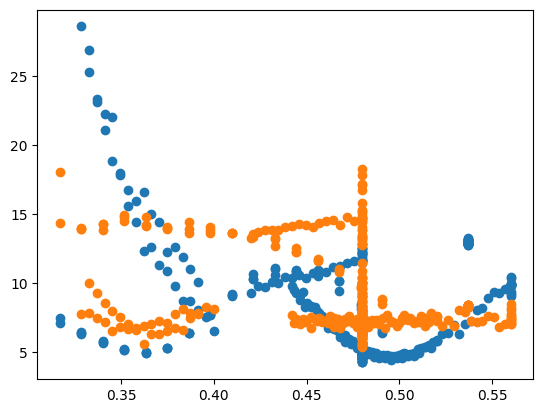

In [8]:
fig, ax = plt.subplots()
ax.scatter(new_df.k_qfn01, new_df.sigH)
ax.scatter(new_df.k_qfn01, new_df.sigV)

In [9]:
# new_df = new_df.iloc[0:16]

In [10]:
# 2 GeV
# Select all measurements available
new_df = pd.DataFrame()

j = 0
for i in range(len(filenames)):
    with open(start_path+filenames[i], 'rb') as handle:
        df = pickle.load(handle)
        print(filenames[i])
    if filenames[i] in [
        'quad_scan_east_slow_ions_2023_2GeV_2023_09_05_12h15m10s_df.pickle',
        'quad_scan_east_slow_ions_2023_2GeV_2023_09_05_13h19m11s_df.pickle',
        'quad_scan_east_slow_ions_2023_2GeV_2023_09_05_13h57m22s_df.pickle',
        'quad_scan_east_slow_ions_2023_2GeV_2023_09_05_14h37m04s_df.pickle',
        'quad_scan_east_slow_ions_2023_2GeV_2023_09_05_15h13m20s_df.pickle',
        'quad_scan_east_slow_ions_2023_2GeV_2023_09_05_16h19m47s_df.pickle',
        'quad_scan_east_slow_ions_2023_2GeV_2023_10_02_09h23m05s_df.pickle',
        'quad_scan_east_slow_ions_2023_2GeV_2023_10_02_10h11m04s_df.pickle',
        'quad_scan_east_slow_ions_2023_2GeV_2023_10_02_10h57m45s_df.pickle',
        'quad_scan_east_slow_ions_2023_2GeV_2023_10_02_11h32m04s_df.pickle',
        'quad_scan_east_slow_ions_2023_2GeV_2023_10_02_11h56m29s_df.pickle',
                        ]:    
        new_df = pd.concat([new_df,df])

new_df.reset_index(inplace=True)


# # 1.4 GeV
# # Select all measurements available
# new_df = pd.DataFrame()

# j = 0
# for i in range(len(filenames)):
#     with open(start_path+filenames[i], 'rb') as handle:
#         df = pickle.load(handle)
#         print(filenames[i])
#     if filenames[i] in [
#         # 'quad_scan_east_slow_ions_2023_1_4GeV_2023_10_02_13h11m25s_df.pickle',
#         # 'quad_scan_east_slow_ions_2023_1_4GeV_2023_10_02_13h58m16s_df.pickle',
#         # 'quad_scan_east_slow_ions_2023_1_4GeV_2023_10_02_14h59m19s_df.pickle',
#         # 'quad_scan_east_slow_ions_2023_1_4GeV_2023_10_09_14h27m51s_df.pickle',
#         'quad_scan_east_slow_ions_2023_1_4GeV_2023_10_09_15h07m39s_df.pickle',
#         'quad_scan_east_slow_ions_2023_1_4GeV_2023_10_09_15h50m08s_df.pickle',
#                         ]:    
#         new_df = pd.concat([new_df,df])

# new_df.reset_index(inplace=True)

# 1.0 GeV
# Select all measurements available
# new_df = pd.DataFrame()

# j = 0
# for i in range(len(filenames)):
#     with open(start_path+filenames[i], 'rb') as handle:
#         df = pickle.load(handle)
#         print(filenames[i])
#     if filenames[i] in [
#         'quad_scan_east_slow_ions_2023_1GeV_2023_10_09_16h49m30s_df.pickle',
#         'quad_scan_east_slow_ions_2023_1GeV_2023_10_09_17h06m57s_df.pickle',
#                         ]:
#         new_df = pd.concat([new_df,df])

# new_df.reset_index(inplace=True)

quad_scan_east_slow_ions_2023_2GeV_2023_09_05_12h15m10s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_09_05_13h19m11s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_09_05_13h57m22s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_09_05_14h37m04s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_09_05_15h13m20s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_09_05_16h19m47s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_10_02_09h23m05s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_10_02_10h11m04s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_10_02_10h57m45s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_10_02_11h32m04s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_10_02_11h56m29s_df.pickle


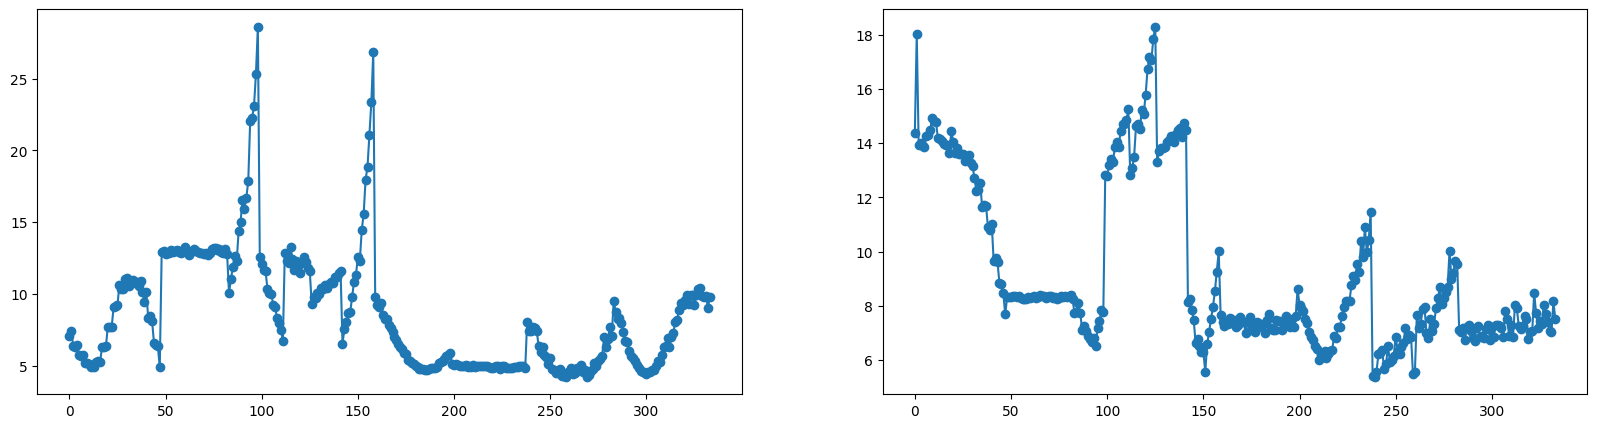

In [24]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(new_df.sigH, marker="o", label="Measurements")
ax[1].plot(new_df.sigV, marker="o", label="Measurements")

# Optimize on a dataframe

In [25]:
E_cin_per_nucleon = 2.0

# Ion properties
A = 208.0
Z = 82.0
N = 126.0
charge = 54.0
m_proton_GeV = 0.93828
m_neutron_GeV = 0.93957
m_electron_GeV = 0.000511
m_u_GeV = 0.9315
mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)

gamma = p/charge/0.938
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread


#################################### Initialize MADX ####################################

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.ele").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.str").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.seq").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.dbx").text) 
madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx.use(sequence="f61d")

btv="f61.btv010"
params = [150, 33.2, -11.1, 0.28, 0.13, 0.0, 0.02, 0.0, 1.5e-6, 1.5e-6, 7.53e-4]
betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, exn, eyn, sige = params

H_sigma_madx_list = []
V_sigma_madx_list = []
for i in range(len(new_df)):

    k_qfn01 = new_df.iloc[i].k_qfn01
    k_qdn02 = new_df.iloc[i].k_qdn02
    k_qfn03 = new_df.iloc[i].k_qfn03

    madx.input("kQFN1 = "+str(k_qfn01)+";")
    madx.input("kQDN2 = "+str(k_qdn02)+";")
    madx.input("kQFN3 = "+str(k_qfn03)+";")

    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
    # *[ ] add air scattering

    H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
    V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000

    H_sigma_madx_list.append(H_sigma_madx)
    V_sigma_madx_list.append(V_sigma_madx)

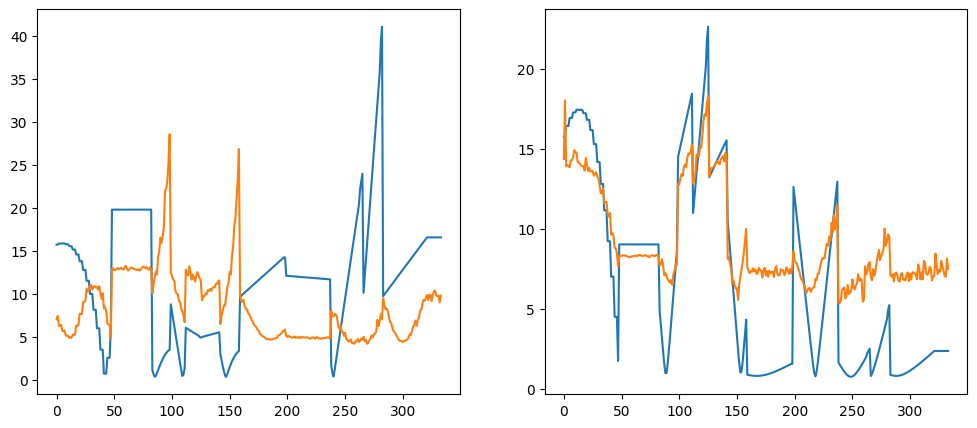

In [26]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(H_sigma_madx_list)
ax[0].plot(new_df.sigH)

ax[1].plot(V_sigma_madx_list)
ax[1].plot(new_df.sigV)

In [27]:
import datetime
index_btv = np.where(twiss_f61d['name'] == "f61.btv010:1")

In [28]:
import datetime
time = datetime.datetime.now()
twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
print(datetime.datetime.now() - time)

0:00:00.025138


In [29]:
import datetime
index_btv = np.where(twiss_f61d['name'] == "f61.btv010:1")

In [30]:
time = datetime.datetime.now()
twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
H_sigma_madx = ( beam_size(float(twiss_f61d['betx'][index_btv][0]), float(twiss_f61d['dx'][index_btv][0]), ex, sige, 1) )*1000
print(datetime.datetime.now() - time)

0:00:00.001439


In [31]:
import datetime

# Number of runs to calculate the average
num_runs = 1000
total_execution_time = datetime.timedelta(0)

for _ in range(num_runs):
    start_time = datetime.datetime.now()

    # Your code block
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
    H_sigma_madx = (beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1)) * 1000

    end_time = datetime.datetime.now()
    execution_time = end_time - start_time
    total_execution_time += execution_time

# Calculate the average execution time
average_execution_time = total_execution_time / num_runs
print(f"Average Execution Time for {num_runs} runs: {average_execution_time}")


Average Execution Time for 1000 runs: 0:00:00.009910


In [32]:
import datetime

# Number of runs to calculate the average
num_runs = 1000
total_execution_time = datetime.timedelta(0)

for _ in range(num_runs):
    start_time = datetime.datetime.now()

    # Your code block
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0)
    H_sigma_madx = (beam_size(float(twiss_f61d['betx'][index_btv][0]), float(twiss_f61d['dx'][index_btv][0]), ex, sige, 1)) * 1000

    end_time = datetime.datetime.now()
    execution_time = end_time - start_time
    total_execution_time += execution_time

# Calculate the average execution time
average_execution_time = total_execution_time / num_runs
print(f"Average Execution Time for {num_runs} runs: {average_execution_time}")


Average Execution Time for 1000 runs: 0:00:00.000620


# Simple Py-Bobyqua

In [33]:
# Py-BOBYQA

E_cin_per_nucleon = 2.0

# Ion properties
A = 208.0
Z = 82.0
N = 126.0
charge = 54.0
m_proton_GeV = 0.93828
m_neutron_GeV = 0.93957
m_electron_GeV = 0.000511
m_u_GeV = 0.9315
mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)

gamma = p/charge/0.938
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread

print(beta, gamma)


0.9961546745721834 11.413960231388458


In [34]:
# Py-BOBYQA

E_cin_per_nucleon = 2.0

# Ion properties
A = 208.0
Z = 82.0
N = 126.0
charge = 54.0
m_proton_GeV = 0.93828
m_neutron_GeV = 0.93957
m_electron_GeV = 0.000511
m_u_GeV = 0.9315
mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)

gamma = p/charge/0.938
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread


In [35]:
# Py-BOBYQA

E_cin_per_nucleon = 2.0

# Ion properties
A = 208.0
Z = 82.0
N = 126.0
charge = 54.0
m_proton_GeV = 0.93828
m_neutron_GeV = 0.93957
m_electron_GeV = 0.000511
m_u_GeV = 0.9315
mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)

gamma = p/charge/0.938
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
sige = 7.53e-4 # Energy spread


#################################### Initialize MADX ####################################

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.ele").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.str").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.seq").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.dbx").text) 
madx.command.beam(particle='PROTON',pc=str(p/charge),ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx.use(sequence="f61d")

btv="f61.btv010"


iter = 0
# Define the objective function
def f_fit(params):

    global iter
    print("Iteration: ", iter)
    iter += 1
    print(params)

    betx0, bety0, alfx0, alfy0, exn, eyn = params

    dx0 = 0.08552983
    dpx0 = 0.01723517
    dy0 = -0.0026243
    dpy0 = -0.00475684
    sige = 0.0045

    ex = exn/(beta*gamma)
    ey = eyn/(beta*gamma)

    madx.command.beam(particle='PROTON',pc=str(p/charge),ex=ex,ey=ey)

    H_sigma_madx_list = []
    V_sigma_madx_list = []
    for i in range(len(new_df)):

        k_qfn01 = new_df.iloc[i].k_qfn01
        k_qdn02 = new_df.iloc[i].k_qdn02
        k_qfn03 = new_df.iloc[i].k_qfn03

        madx.input("kQFN1 = "+str(k_qfn01)+";")
        madx.input("kQDN2 = "+str(k_qdn02)+";")
        madx.input("kQFN3 = "+str(k_qfn03)+";")

        twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
        # *[ ] add air scattering

        H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
        V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000

        H_sigma_madx_list.append(H_sigma_madx)
        V_sigma_madx_list.append(V_sigma_madx)

    # Objective

    objective_H = np.array(abs(H_sigma_madx_list-new_df.sigH)**2).sum()
    objective_V = np.array(abs(V_sigma_madx_list-new_df.sigV)**2).sum()

    objective = objective_H + objective_V
    print(objective)
    print("")

    # Monitor Objective
    with open('progress.csv', 'a') as file:
        line = ','.join(map(str, [betx0, alfx0, dx0, dpx0, exn, sige, objective]))
        file.write(line + '\n')

    return objective

initial_guess = [53.074, 3.675, -13.191, 0.859, 2.53e-5, 6.94e-06]

lower = np.array([1, 1, -50, -100, 0.0, 0.0])
upper = np.array([200, 50, 0, 100, 5.0e-5, 5.0e-5])

# Open the file in write mode, which will erase its contents
with open('progress.csv', 'w') as file:
    pass  # This line does nothing, but it ensures the file is opened and immediately closed
# The contents of 'progress.csv' are now erased

# Call Py-BOBYQA
soln = pybobyqa.solve(f_fit, initial_guess, bounds=(lower, upper), rhobeg=0.5, objfun_has_noise=False, seek_global_minimum=False, scaling_within_bounds=True, rhoend=1e-5, maxfun=500)

# Display output
print(soln)

Iteration:  0
[ 5.3074e+01  3.6750e+00 -1.3191e+01  8.5900e-01  2.5300e-05  6.9400e-06]
1348.3915520970472

Iteration:  1
[ 1.52574e+02  3.67500e+00 -1.31910e+01  8.59000e-01  2.53000e-05
  6.94000e-06]


KeyboardInterrupt: 

In [24]:
soln.x

array([ 6.67479971e+01,  3.76412474e+00, -1.62722259e+01,  7.03346313e-01,
        2.28304416e-05,  8.63495536e-06])

In [ ]:
betx0 = 6.67479971e+01
bety0 = 3.76412474e+00
alfx0 = -1.62722259e+01
alfy0 = 7.03346313e-01
exn = 2.28304416e-05
eyn = 8.63495536e-06

In [41]:
# Try solution

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.ele").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.str").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.seq").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.dbx").text) 
madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx.use(sequence="f61d")

btv="f61.btv010"

# betx0 = soln.x[0]
# bety0 = soln.x[1]
# alfx0 = soln.x[2]
# alfy0 = soln.x[3]

dx0 = 0.08552983
dy0 = -0.0026243
dpx0 = 0.01723517
dpy0 = -0.00475684

# exn = soln.x[4]
# eyn = soln.x[5]
sige = 0.0045

betx0 = 6.67479971e+01
bety0 = 3.76412474e+00
alfx0 = -1.62722259e+01
alfy0 = 7.03346313e-01
exn = 2.28304416e-05
eyn = 8.63495536e-06

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)

H_sigma_madx_list = []
V_sigma_madx_list = []

for i in range(len(new_df)):

    k_qfn01 = new_df.iloc[i].k_qfn01
    k_qdn02 = new_df.iloc[i].k_qdn02
    k_qfn03 = new_df.iloc[i].k_qfn03

    madx.input("kQFN1 = "+str(k_qfn01)+";")
    madx.input("kQDN2 = "+str(k_qdn02)+";")
    madx.input("kQFN3 = "+str(k_qfn03)+";")

    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
    # *[ ] add air scattering

    H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
    V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000

    H_sigma_madx_list.append(H_sigma_madx)
    V_sigma_madx_list.append(V_sigma_madx)

objective_H = np.array(abs(H_sigma_madx-new_df.sigH)**2).sum()
objective_V = np.array(abs(H_sigma_madx-new_df.sigH)**2).sum()
objective = objective_H + objective_V
print (objective)

18419.566999881376


Text(0.7, 0.95, 'Matched initial parameters:\n$p/q$=10.706\n$\\beta_{x}$=66.748\n$\\beta_{y}$=3.764\n$\\alpha_{x}$=-16.272\n$\\alpha_{y}$=0.703\n$D_{x}$=0.086\n$D_{y}$=-0.003\n$D_{px}$=0.017\n$D_{py}$=-0.005\n$exn$=2.283e-05\n$eyn$=8.63e-06\n$\\frac{dp}{p}$=0.0045')

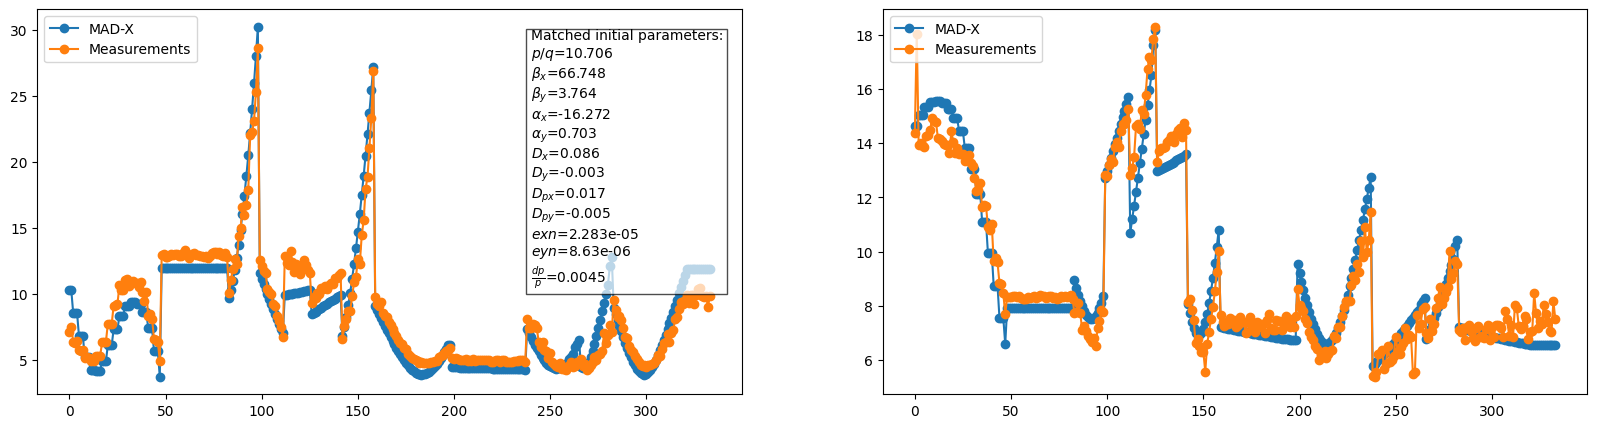

In [42]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

# H
ax[0].plot(H_sigma_madx_list, marker="o", label="MAD-X")
ax[0].plot(new_df.sigH, marker="o", label="Measurements")

# V
ax[1].plot(V_sigma_madx_list, marker="o", label="MAD-X")
ax[1].plot(new_df.sigV, marker="o", label="Measurements")

ax[0].legend(loc = "upper left")
ax[1].legend(loc = "upper left")

# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$p/q$='+str(round(p/charge,3)),
    r'$\beta_{x}$='+str(round(betx0,3)),
    r'$\beta_{y}$='+str(round(bety0,3)),
    r'$\alpha_{x}$='+str(round(alfx0,3)),
    r'$\alpha_{y}$='+str(round(alfy0,3)),
    r'$D_{x}$='+str(round(dx0,3)),
    r'$D_{y}$='+str(round(dy0,3)),
    r'$D_{px}$='+str(round(dpx0,3)),
    r'$D_{py}$='+str(round(dpy0,3)),
    r'$exn$='+str(round(exn,8)),
    r'$eyn$='+str(round(eyn,8)),
    r'$\frac{dp}{p}$='+str(round(sige,6)),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.7)

# place a text box in upper left in axes coords
ax[0].text(0.7, 0.95, textstr, transform=ax[0].transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

In [43]:
betx0 = 6.67479971e+01
bety0 = 3.76412474e+00
alfx0 = -1.62722259e+01
alfy0 = 7.03346313e-01
exn = 2.28304416e-05
eyn = 8.63495536e-06

Text(0.5, 1.0, 'Difference between measurements and simulations')

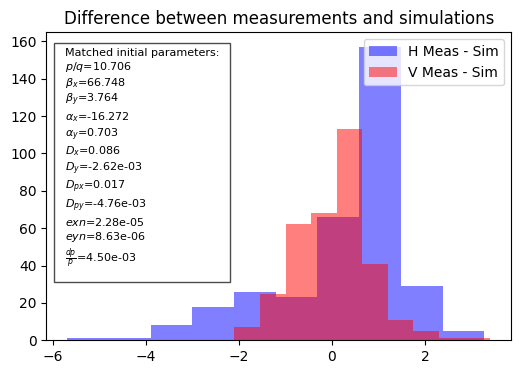

In [44]:
fig, ax = plt.subplots(figsize=(6,4))

ax.hist(new_df.sigH-H_sigma_madx_list, label="H Meas - Sim", color="b", alpha=0.5, bins=10)
ax.hist(new_df.sigV-V_sigma_madx_list, label="V Meas - Sim", color="r", alpha=0.5, bins=10)

ax.legend(loc = "upper right")

# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    rf'$p/q$={p/charge:.3f}',
    rf'$\beta_{{x}}$={betx0:.3f}',
    rf'$\beta_{{y}}$={bety0:.3f}',
    rf'$\alpha_{{x}}$={alfx0:.3f}',
    rf'$\alpha_{{y}}$={alfy0:.3f}',
    rf'$D_{{x}}$={dx0:.3f}',
    rf'$D_{{y}}$={dy0:.2e}',
    rf'$D_{{px}}$={dpx0:.3f}',
    rf'$D_{{py}}$={dpy0:.2e}',
    rf'$exn$={exn:.2e}',
    rf'$eyn$={eyn:.2e}',
    rf'$\frac{{dp}}{{p}}$={sige:.2e}',
))


props = dict(boxstyle='square', facecolor='white', alpha=0.7, pad=1)

# place a text box in upper left in axes coords
ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)

ax.set_title("Difference between measurements and simulations")

 # Sliders

In [26]:
def beam_size(beta, dispersion, eps, dpp, n):
    """
    Simple calculation of beam size
    """
    beam = np.sqrt(eps*beta + (dpp*dispersion)**2)
    return beam*n

In [27]:
E_cin_per_nucleon = 2

# Ion properties
A = 208.0
Z = 82.0
N = 126.0
charge = 54.0
m_proton_GeV = 0.93828
m_neutron_GeV = 0.93957
m_electron_GeV = 0.000511
m_u_GeV = 0.9315
mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)

rho = 70.0789
Brho = 3.33564 * p / charge

E_cin_proton = np.sqrt(Brho ** 2 + m_proton_GeV ** 2) - m_proton_GeV


B = 3.3356*p/(rho*charge)*10000

print(f"p = {round(p,3)}")
print(f"Brho = {round(Brho/3.3356,3)}")
print(f"B-field = {round(B,1)} [G]")
print(f"E cin proton = {round(E_cin_proton,1)}")

p = 578.14
Brho = 10.706
B-field = 5096.0 [G]
E cin proton = 34.8


In [28]:
import ipywidgets as widgets
from ipywidgets import *
from IPython.display import clear_output

# E_cin_per_nucleon = 2

# # Ion properties
# A = 208.0
# Z = 82.0
# N = 126.0
# charge = 54.0
# m_proton_GeV = 0.93828
# m_neutron_GeV = 0.93957
# m_electron_GeV = 0.000511
# m_u_GeV = 0.9315
# mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
# E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

# p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)

# gamma = p/charge/0.938
# beta = np.sqrt(1-gamma**(-2))
# exn=1.5e-6
# eyn=1.5e-6
# ex = exn/(beta*gamma)
# ey = eyn/(beta*gamma)
# sige = 7.53e-4 # Energy spread

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.ele").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.str").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.seq").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.dbx").text) 
madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx.use(sequence="f61d")


def compute(E_cin_per_nucleon, betx0, alfx0, dx0, dpx0, exn, bety0, alfy0, dy0, dpy0, eyn, sige):

    with output:
        clear_output(wait=True)

        fig, ax = plt.subplots(1,2, figsize=(20, 5))

        btv="f61.btv010"

        # dx0 = 0.13
        # dy0 = 0.0
        # dpx0 = 0.02
        # dpy0 = 0

        # exn = 7.6e-6
        # eyn = 3.5e-6
        # sige = 6.79e-4
                     

        # Ion properties
        A = 208.0
        Z = 82.0
        N = 126.0
        charge = 54.0
        m_proton_GeV = 0.93828
        m_neutron_GeV = 0.93957
        m_electron_GeV = 0.000511
        m_u_GeV = 0.9315
        mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
        E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

        p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)
        print(f"p = {p}")

        gamma = p/charge/0.938
        beta = np.sqrt(1-gamma**(-2))

        ex = exn/(beta*gamma)
        ey = eyn/(beta*gamma)

        madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)
        madx.input('BRHO      := BEAM->PC * 3.3356;')
        madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
        madx.use(sequence="f61d")

        H_sigma_madx_list = []
        V_sigma_madx_list = []

        for i in range(len(new_df)):

            k_qfn01 = new_df.iloc[i].k_qfn01
            k_qdn02 = new_df.iloc[i].k_qdn02
            k_qfn03 = new_df.iloc[i].k_qfn03

            madx.input("kQFN1 = "+str(k_qfn01)+";")
            madx.input("kQDN2 = "+str(k_qdn02)+";")
            madx.input("kQFN3 = "+str(k_qfn03)+";")

            twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
            # *[ ] add air scattering

            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000

            H_sigma_madx_list.append(H_sigma_madx)
            V_sigma_madx_list.append(V_sigma_madx)

        objective_H = np.array(abs(H_sigma_madx_list-new_df.sigH)**2).sum()
        objective_V = np.array(abs(V_sigma_madx_list-new_df.sigV)**2).sum()
        objective = objective_H + objective_V
        print (objective)

        
        ax[0].plot(H_sigma_madx_list, marker="o", label="MAD-X")
        ax[0].plot(new_df.sigH, marker="o", label="Measurements")

        ax[1].plot(V_sigma_madx_list, marker="o", label="MAD-X")
        ax[1].plot(new_df.sigV, marker="o", label="Measurements")

        ax[0].set_ylim(0,30)
        ax[0].legend(loc="upper right")

        plt.show()


Ecin = widgets.FloatSlider(value=2,
    min=0.5,
    max=5,
    step=0.1,
    description='Ecin',
    layout=Layout(width='1000px'))

betx = widgets.FloatSlider(value=162.6,
    min=100,
    max=200,
    step=0.1,
    description='betx',
    layout=Layout(width='500px'))

alfx = widgets.FloatSlider(value=-40,
    min=-50,
    max=50,
    step=0.1,
    description='alfx',
    layout=Layout(width='500px'))

dx = widgets.FloatSlider(value=0.13,
    min=-5,
    max=5,
    step=0.1,
    description='dx',
    layout=Layout(width='500px'))

dpx = widgets.FloatSlider(value=0.0,
    min=-5,
    max=5,
    step=0.1,
    description='dpx',
    layout=Layout(width='500px'))

exn = widgets.FloatSlider(value=7.6e-6,
    min=1e-6,
    max=50e-6,
    step=0.1e-6,
    description='exn',
    layout=Layout(width='500px'),
    readout_format='.1e',)

bety = widgets.FloatSlider(value=5.2,
    min=1,
    max=20,
    step=0.1,
    description='bety',
    layout=Layout(width='500px'))

alfy = widgets.FloatSlider(value=0.25,
    min=-5,
    max=5,
    step=0.1,
    description='alfy',
    layout=Layout(width='500px'))

dy = widgets.FloatSlider(value=0.0,
    min=-5,
    max=5,
    step=0.1,
    description='dy',
    layout=Layout(width='500px'))

dpy = widgets.FloatSlider(value=0.0,
    min=-5,
    max=5,
    step=0.1,
    description='dpy',
    layout=Layout(width='500px'))

eyn = widgets.FloatSlider(value=3.5e-6,
    min=1e-6,
    max=50e-6,
    step=0.1e-6,
    description='eyn',
    layout=Layout(width='500px'),
    readout_format='.1e',)

sige = widgets.FloatSlider(value=6.79e-4,
    min=1e-4,
    max=10e-4,
    step=0.1e-4,
    description='sige',
    layout=Layout(width='1000px'),
    readout_format='.1e',)

output = widgets.Output()
button = widgets.Button(description="Simulate")



display(Ecin, widgets.HBox([widgets.VBox([betx, alfx, dx, dpx, exn]), widgets.VBox([bety, alfy, dy, dpy, eyn])]),sige, button, output)
    

def on_button_clicked(b):
    with output:
        print("Calculating...")
        compute(Ecin.value, betx.value, alfx.value, dx.value, dpx.value, exn.value, bety.value, alfy.value, dy.value, dpy.value, eyn.value, sige.value)


button.on_click(on_button_clicked)

# Attach the value change event handler to the sliders
# Ecin.observe(on_button_clicked, names='value')
# betx.observe(on_button_clicked, names='value')
# alfx.observe(on_button_clicked, names='value')
# dx.observe(on_button_clicked, names='value')
# exn.observe(on_button_clicked, names='value')
# sige.observe(on_button_clicked, names='value')

# ****** Py-BOBYQA Results ******
# Solution xmin = [ 1.85570681e+02  2.87266838e+00 -4.06425819e+01  5.07125319e-02
#   2.51043598e-06  3.27734009e-06  5.14204337e-04]

FloatSlider(value=2.0, description='Ecin', layout=Layout(width='1000px'), max=5.0, min=0.5)

FloatSlider(value=0.000679, description='sige', layout=Layout(width='1000px'), max=0.001, min=0.0001, readout_…

Button(description='Simulate', style=ButtonStyle())

Output()

# Test the air scattering

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from cpymad.madx import Madx
import pandas as pd
from pybt.tools.plotters import *
from madxtools.plot_tool import *

def manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, L, scattering=False):
    """
    This function manipulates the global variables of a MADX instance and returns the new beta functions and emittance.
    If the scattering parameter is set to True, it also calculates the new emittance due to scattering.

    Parameters:
    madx (cpymad.madx.Madx): An instance of the MADX class.
    exn (float): The normalized horizontal emittance.
    eyn (float): The normalized vertical emittance.
    p (float): The momentum of the beam.
    beta (float): The relativistic beta factor.
    gamma (float): The relativistic gamma factor.
    L (float): The length of the air region.
    scattering (bool): A boolean indicating whether to calculate the new emittance due to scattering.

    Returns:
    betx0 (float): The new horizontal beta function.
    bety0 (float): The new vertical beta function.
    alfx0 (float): The new horizontal alpha function.
    alfy0 (float): The new vertical alpha function.
    dx0 (float): The new horizontal dispersion.
    dy0 (float): The new vertical dispersion.
    dpx0 (float): The new horizontal momentum deviation.
    dpy0 (float): The new vertical momentum deviation.
    exn (float): The new horizontal emittance.
    eyn (float): The new vertical emittance.
    """

    madx.globals['betx0'] = 'savebeta_air->betx'
    madx.globals['bety0'] = 'savebeta_air->bety'
    madx.globals['alfx0'] = 'savebeta_air->alfx'
    madx.globals['alfy0'] = 'savebeta_air->alfy'
    madx.globals['dx0'] = 'savebeta_air->dx'
    madx.globals['dy0'] = 'savebeta_air->dy'
    madx.globals['dpx0'] = 'savebeta_air->dpx'
    madx.globals['dpy0'] = 'savebeta_air->dpy'

    if scattering==True:
        
        epsilon_0 = exn/(beta*gamma)
        epsilon_0_V = eyn/(beta*gamma)

        p_MeV = p*1000 # Beam total energy in MeV
        q = 1
        P = 1.01325 # Standard air pressure at sea level in Bar
        P_Torr = P*750.062 # Standard air pressure at sea level in Torr
        L_rad0 = 301 # For air. Table with radiation lengths: https://cds.cern.ch/record/941314/files/p245.pdf
        L_rad = L_rad0/(P_Torr/760)

        theta_rms = (13.6/p_MeV*beta)*q*np.sqrt(L/L_rad)

        # Horizontal
        gamma0 = (1 + madx.globals['alfx0']**2) / madx.globals['betx0']
        Delta_epsilon = (1/2)*theta_rms**2*(madx.globals['betx0'] + L*madx.globals['alfx0'] + (L**2/3)*gamma0)
        epsilon_1 = epsilon_0 + Delta_epsilon
        alfx0_1 = (epsilon_0*madx.globals['alfx0'] - (L/2)*theta_rms**2 ) / (epsilon_0 + Delta_epsilon)
        betx0_1 = (epsilon_0*madx.globals['betx0'] + (L**2/3)*theta_rms**2 ) / (epsilon_0 + Delta_epsilon)

        # Vertical
        gamma0_V = (1 + madx.globals['alfy0']**2) / madx.globals['bety0']
        Delta_epsilon_V = (1/2)*theta_rms**2*(madx.globals['bety0'] + L*madx.globals['alfy0'] + (L**2/3)*gamma0_V)
        epsilon_1_V = epsilon_0_V + Delta_epsilon_V
        alfy0_1 = (epsilon_0_V*madx.globals['alfy0'] - (L/2)*theta_rms**2 ) / (epsilon_0_V + Delta_epsilon_V)
        bety0_1 = (epsilon_0_V*madx.globals['bety0'] + (L**2/3)*theta_rms**2 ) / (epsilon_0_V + Delta_epsilon_V)

        # Return
        exn = epsilon_1*beta*gamma
        eyn = epsilon_1_V*beta*gamma
        betx0 = betx0_1
        alfx0 = alfx0_1
        bety0 = bety0_1
        alfy0 = alfy0_1
        
    else:
        betx0 = madx.globals['betx0']
        alfx0 = madx.globals['alfx0']
        bety0 = madx.globals['bety0']
        alfy0 = madx.globals['alfy0']
    
    dx0 = madx.globals['dx0']
    dy0 = madx.globals['dy0']
    dpx0 = madx.globals['dpx0']
    dpy0 = madx.globals['dpy0']

    return betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, exn, eyn

def add_air_region(madx, title, sequence, air_start_pos, air_stop_pos, steps):
    """
    This function adds an air region to the MADX sequence.

    Parameters:
    madx (cpymad.madx.Madx): An instance of the MADX class.
    air_start_pos (float): The starting position of the air region.
    air_stop_pos (float): The stopping position of the air region.
    steps (float): The distance between two consecutive inner markers.

    Returns:
    None
    """

    # Calculate the positions of the inner markers
    inner_marker_array = np.arange(air_start_pos+steps, air_stop_pos, steps)

    # Add the markers for the start and end of the air region
    madx.input(f'''
    AIR_START : MARKER;
    AIR_END : MARKER;
    ''')           

    # Install the markers for the start and end of the air region
    madx.input(f'''
    SEQEDIT, SEQUENCE={sequence};
    INSTALL, ELEMENT=AIR_START, CLASS=AIR_START, AT={air_start_pos};
    INSTALL, ELEMENT=AIR_END, CLASS=AIR_END, AT={air_stop_pos};
    ENDEDIT;
    ''')

    # Add the inner markers
    madx.input(f"SEQEDIT, SEQUENCE = {sequence};")
    # Create a for loop for the inner markers:
    for count, pos in enumerate(inner_marker_array):
        madx.input(f"INSTALL, ELEMENT=INNER_MARKER{str(count)}_{title}, CLASS=MARKER, AT={pos};")
        # print(f"INNER_MARKER{str(count)}")
    madx.input("ENDEDIT;")

    return

def add_hidden_marker(madx, sequence, start, stop, steps):
    # Add marker at the end of the line to see the evolution of the beam with fine resolution
    madx.input(f"SEQEDIT, SEQUENCE = {sequence};")
    for count, pos in enumerate(np.arange(start, stop, steps)):
        madx.input(f"INSTALL, ELEMENT=HIDDEN_MARKER{str(count)}, CLASS=MARKER, AT={pos};")
    madx.input("ENDEDIT;")

    return

def process_scattering(madx, exn, eyn, beta, gamma, sequence, end, p, twiss_initial, ex_initial, ey_initial):

    air_start_elements = [name for name in twiss_initial.name if "air_start" in name]
    # print(f"There are {len(air_start_elements)} air regions in the sequence: {air_start_elements}")

    air_start_numbers = [int(name.split(':')[1]) for name in air_start_elements]
    # print(f"The air regions are numbered: {air_start_numbers}")

    inner_elements = [name for name in twiss_initial.name if "inner" in name]

    def update_beam(madx, exn, eyn, beta, gamma, ex_list, ey_list):
        madx.command.beam(ex=exn/(beta*gamma), ey=eyn/(beta*gamma))
        ex_list.append(madx.sequence[sequence].beam.ex)
        ey_list.append(madx.sequence[sequence].beam.ey)
        return madx, ex_list, ey_list

    def append_twiss_to_list(madx, sequence, twiss_list, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0):
        madx.use(sequence=sequence)
        twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
        twiss_list.append(twiss)
        return twiss_list

    twiss_list = []
    ex_list = []
    ey_list = []

    betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, exn, eyn = manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, scattering=False, L=0)

    madx.input(f"SEQEDIT, SEQUENCE = {sequence};")
    madx.input(f"EXTRACT, SEQUENCE = {sequence}, FROM=AIR_START, TO={end}, NEWNAME=seq_air_start_to_end;")
    madx.input("ENDEDIT;")

    previous_seq_name = "seq_air_start_to_end"

    # Iterating over all air regions
    for air_region_number in air_start_numbers:
        # print(f"Entering air region {air_region_number}")

        if air_region_number == 1:
            air_start_pos = madx.sequence[sequence].elements["air_start"].position

        else:
            air_start_pos = madx.sequence[sequence].elements[f"air_start[{str(air_region_number)}]"].position

        # print(air_start_pos)

        inner_marker_list = [name for name in inner_elements if name.endswith(f"{air_region_number}:1")]
        for i in range(len(inner_marker_list)):

            if i == 0:
                step = madx.sequence[sequence].elements[inner_marker_list[i][:-2]].position - air_start_pos
            else:
                step = madx.sequence[sequence].elements[inner_marker_list[i][:-2]].position - madx.sequence[sequence].elements[inner_marker_list[i-1][:-2]].position

            madx, ex_list, ey_list = update_beam(madx, exn, eyn, beta, gamma, ex_list, ey_list)

            # print(f"SAVEBETA at INNER_MARKER{str(i)}_{str(air_region_number)}")
            madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = INNER_MARKER{str(i)}_{str(air_region_number)}, SEQUENCE={previous_seq_name};")
            twiss_list = append_twiss_to_list(madx,previous_seq_name, twiss_list, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)
            betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, exn, eyn = manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, scattering=True, L=step)

            # print(f"Extracting from INNER_MARKER{str(i)}_{str(air_region_number)} to {end}")
            madx.input(f"SEQEDIT, SEQUENCE = {previous_seq_name};")
            madx.input(f"EXTRACT, SEQUENCE= {previous_seq_name}, FROM=INNER_MARKER{str(i)}_{str(air_region_number)}, TO={end}, NEWNAME=seq_inner_marker{str(i)}_to_end;")
            madx.input("ENDEDIT;")

            previous_seq_name = f"seq_inner_marker{str(i)}_to_end"
        
        madx, ex_list, ey_list = update_beam(madx, exn, eyn, beta, gamma, ex_list, ey_list)

        #### Air_END ####
        # Final step calculation
        if air_region_number == 1:
            air_end_pos = madx.sequence[sequence].elements["air_end"].position
            step = air_end_pos - madx.sequence[sequence].elements[inner_marker_list[i][:-2]].position
        else:
            air_end_pos = madx.sequence[sequence].elements[f"air_end[{str(air_region_number)}]"].position
            step = air_end_pos - madx.sequence[sequence].elements[inner_marker_list[i][:-2]].position

        # print(f"SAVEBETA at AIR_END")
        if air_region_number == 0:
            madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_END, SEQUENCE={previous_seq_name};")
        else:
            madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_END[{str(air_region_number)}], SEQUENCE={previous_seq_name};")

        twiss_list = append_twiss_to_list(madx,previous_seq_name, twiss_list, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)
        betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, exn, eyn = manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, scattering=True, L=step)
        
        madx.input(f"SEQEDIT, SEQUENCE = {previous_seq_name};")
        if air_region_number == 1:
            # print(f"Extracting from AIR_END to {end}")
            madx.input(f"EXTRACT, SEQUENCE= {previous_seq_name}, FROM=AIR_END, TO={end}, NEWNAME=seq_air_end_to_end;")
        else:
            # print(f"Extracting from AIR_END[{str(air_region_number)}] to {end}")
            madx.input(f"EXTRACT, SEQUENCE= {previous_seq_name}, FROM=AIR_END, TO={end}, NEWNAME=seq_air_end{str(air_region_number)}_to_end;")
        madx.input("ENDEDIT;")

        
        if air_region_number == 1:
            previous_seq_name = f"seq_air_end_to_end"
        else:
            previous_seq_name = f"seq_air_end{str(air_region_number)}_to_end"

        twiss_list = append_twiss_to_list(madx,previous_seq_name, twiss_list, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)
        madx, ex_list, ey_list = update_beam(madx, exn, eyn, beta, gamma, ex_list, ey_list)


    # Shift the s position so that is is coherent.
    for i in range(len(twiss_list)):
        twiss_list[i].s = twiss_list[i].s + twiss_initial.loc[twiss_list[i].iloc[1].name].s


    # We add the emittances to each twiss table
    twiss_initial['ex'] = ex_initial

    for i in range(len(twiss_list)):
        twiss_list[i]['ex'] = ex_list[i]

    twiss_initial['ey'] = ey_initial

    for i in range(len(twiss_list)):
        twiss_list[i]['ey'] = ey_list[i]

    # We remove the drifts as they are duplicated names
    def remove_drift_rows(df):
        df = df.loc[~df.index.str.startswith('drift')]
        df = df.loc[~df.index.str.startswith('#s')]
        return df

    twiss_list = [remove_drift_rows(df) for df in twiss_list]

    # We combine all the twiss tables into one
    def add_missing_rows(df1, df2):
        # Find rows in df1 with lower 's' than the minimum 's' in df2
        missing_rows = df1[df1['s'] < df2['s'].min()]
        
        # Append these rows to df2 and sort by 's'
        df2_updated = pd.concat([df2, missing_rows]).sort_values(by='s')

        return df2_updated

    # Loop through each element in the list
    for i in range(1, len(twiss_list)):
        twiss_list[i] = add_missing_rows(twiss_list[i-1], twiss_list[i])

    # Finaly, we add the initial twiss table to the beginning
    twiss_scattered = add_missing_rows(twiss_initial, twiss_list[-1])

    return twiss_initial, twiss_scattered

 55%|█████▌    | 184/334 [02:18<01:53,  1.33it/s]


KeyboardInterrupt: 

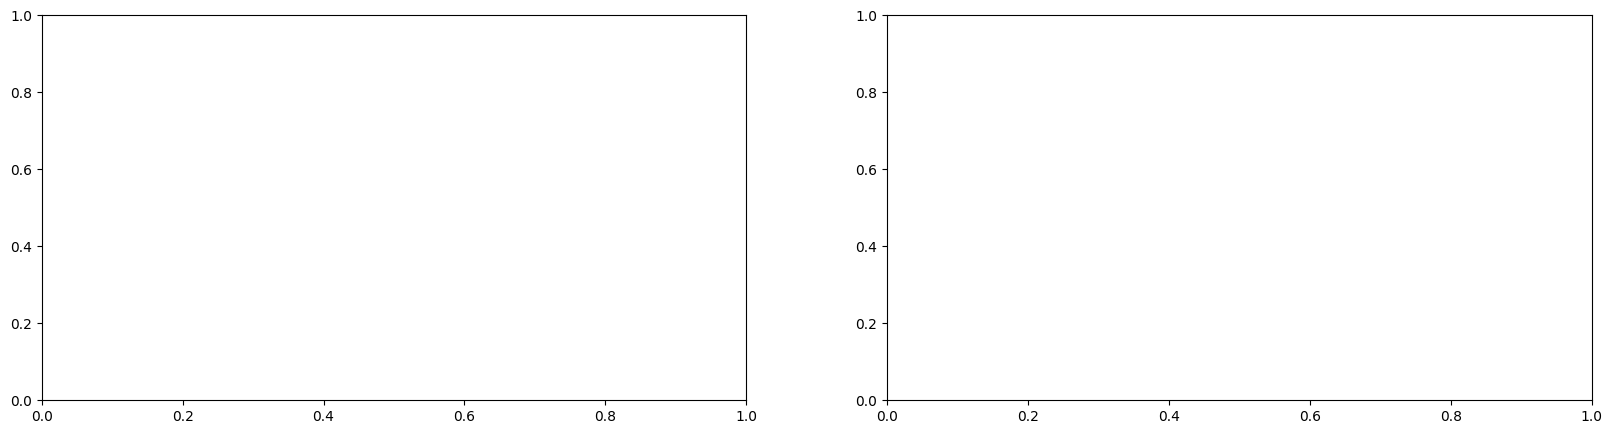

In [30]:
from tqdm import tqdm

fig, ax = plt.subplots(1,2, figsize=(20, 5))

H_sigma_madx_list = []
V_sigma_madx_list = []
H_sigma_madx_list_scattered = []
V_sigma_madx_list_scattered = []



for item in tqdm(new_df.iterrows(), total=len(new_df)):
    
    i = item[0]

    with open('tempfile', 'w') as f:
        madx = Madx(stdout=f,stderr=f)
        madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)
    madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.ele").text) 
    madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.str").text) 
    madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.seq").text) 
    madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.dbx").text) 
    madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)
    madx.input('BRHO      := BEAM->PC * 3.3356;')
    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
    madx.use(sequence="f61d")


    E_cin_per_nucleon = 2.0

    btv="f61.btv010"

    betx0 = 142.664
    bety0 = 3.293
    alfx0 = -34.945
    alfy0 = 0.61
    exn = 1.1e-05
    eyn = 8e-06
    sige = 0.000771
    dx0 = 0.13
    dpx0 = 0.0
    dy0 = 0.02
    dpy0 = 0.0
                    


    # Ion properties
    A = 208.0
    Z = 82.0
    N = 126.0
    charge = 54.0
    m_proton_GeV = 0.93828
    m_neutron_GeV = 0.93957
    m_electron_GeV = 0.000511
    m_u_GeV = 0.9315
    mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
    E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

    p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)

    gamma = p/charge/0.938
    beta = np.sqrt(1-gamma**(-2))

    ex = exn/(beta*gamma)
    ex_initial = ex
    ey = eyn/(beta*gamma)
    ey_initial = ey

    # Add the Air region
    sequence = "f61d"

    p1 = madx.sequence['f61d'].elements["f61.btv012"].position - 0.5 # This dimension needs to be checked
    p2 = madx.sequence['f61d'].elements["f61.btv012"].position
    add_air_region(madx, "1", sequence, p1, p2, (p2-p1)/2)

    p1 = madx.sequence['f61d'].elements["f61.bctf022"].position
    p2 = madx.sequence['f61d'].elements["f61.mbxhd025"].position + madx.sequence['f61d'].elements["f61.mbxhd025"].length + 0.3
    add_air_region(madx, "2", sequence, p1, p2, p2-p1-0.3)

    madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)
    madx.input('BRHO      := BEAM->PC * 3.3356;')
    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
    madx.use(sequence="f61d")

    # make thin
    madx.use(sequence="f61d")
    madx.input('SEQEDIT, sequence=f61d;')
    madx.input('FLATTEN;')
    madx.input('ENDEDIT;')
    madx.use(sequence="f61d")
    madx.input("SELECT, FLAG=makethin, CLASS=dipole, SLICE=3;")
    # madx.input("MAKETHIN, SEQUENCE=f61d, style=TEAPOT")
    madx.use(sequence="f61d")

    twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

    k_qfn01 = new_df.iloc[i].k_qfn01
    k_qdn02 = new_df.iloc[i].k_qdn02
    k_qfn03 = new_df.iloc[i].k_qfn03

    madx.input("kQFN1 = "+str(k_qfn01)+";")
    madx.input("kQDN2 = "+str(k_qdn02)+";")
    madx.input("kQFN3 = "+str(k_qfn03)+";")

    madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_START, SEQUENCE={sequence};")
    twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
    twiss, twiss_scattered = process_scattering(madx, exn, eyn, beta, gamma, sequence, "f61.end", p/charge, twiss, ex_initial, ey_initial)

    H_sigma_madx = ( beam_size(twiss['betx'][btv], twiss['dx'][btv], ex, sige, 1) )*1000
    V_sigma_madx = ( beam_size(twiss['bety'][btv], twiss['dy'][btv], ey, sige, 1) )*1000

    H_sigma_madx_scattered = ( beam_size(twiss_scattered['betx'][btv], twiss_scattered['dx'][btv], twiss_scattered['ex'][btv], sige, 1) )*1000
    V_sigma_madx_scattered = ( beam_size(twiss_scattered['bety'][btv], twiss_scattered['dy'][btv], twiss_scattered['ey'][btv], sige, 1) )*1000

    H_sigma_madx_list.append(H_sigma_madx)
    V_sigma_madx_list.append(V_sigma_madx)

    H_sigma_madx_list_scattered.append(H_sigma_madx_scattered)
    V_sigma_madx_list_scattered.append(V_sigma_madx_scattered)


ax[0].plot(H_sigma_madx_list, marker="o", label="MAD-X")
ax[0].plot(H_sigma_madx_list_scattered, marker="o", label="MAD-X Scattered")
ax[0].plot(new_df.sigH, marker="o", label="Measurements")

ax[0].set_ylim(0,30)
ax[0].legend(loc="upper left")

ax[1].plot(V_sigma_madx_list, marker="o", label="MAD-X")
ax[1].plot(V_sigma_madx_list_scattered, marker="o", label="MAD-X Scattered")
ax[1].plot(new_df.sigV, marker="o", label="Measurements")

ax[1].set_ylim(0,30)
ax[1].legend(loc="upper left")

# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$p$='+str(round(p/charge,3)),
    r'$\beta_{x}$='+str(round(betx0,3)),
    r'$\beta_{y}$='+str(round(bety0,3)),
    r'$\alpha_{x}$='+str(round(alfx0,3)),
    r'$\alpha_{y}$='+str(round(alfy0,3)),
    r'$D_{x}$='+str(round(dx0,3)),
    r'$D_{y}$='+str(round(dy0,3)),
    r'$D_{px}$='+str(round(dpx0,3)),
    r'$D_{py}$='+str(round(dpy0,3)),
    r'$exn$='+str(round(exn,8)),
    r'$eyn$='+str(round(eyn,8)),
    r'$\frac{dp}{p}$='+str(round(sige,6)),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.7)

# place a text box in upper left in axes coords
ax[0].text(0.7, 0.95, textstr, transform=ax[0].transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.show()